In [16]:
#move back to the root directory
import os
os.chdir('..')

In [17]:
!pwd

/Users/charlesc/Documents/GitHub/ERP_tools


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


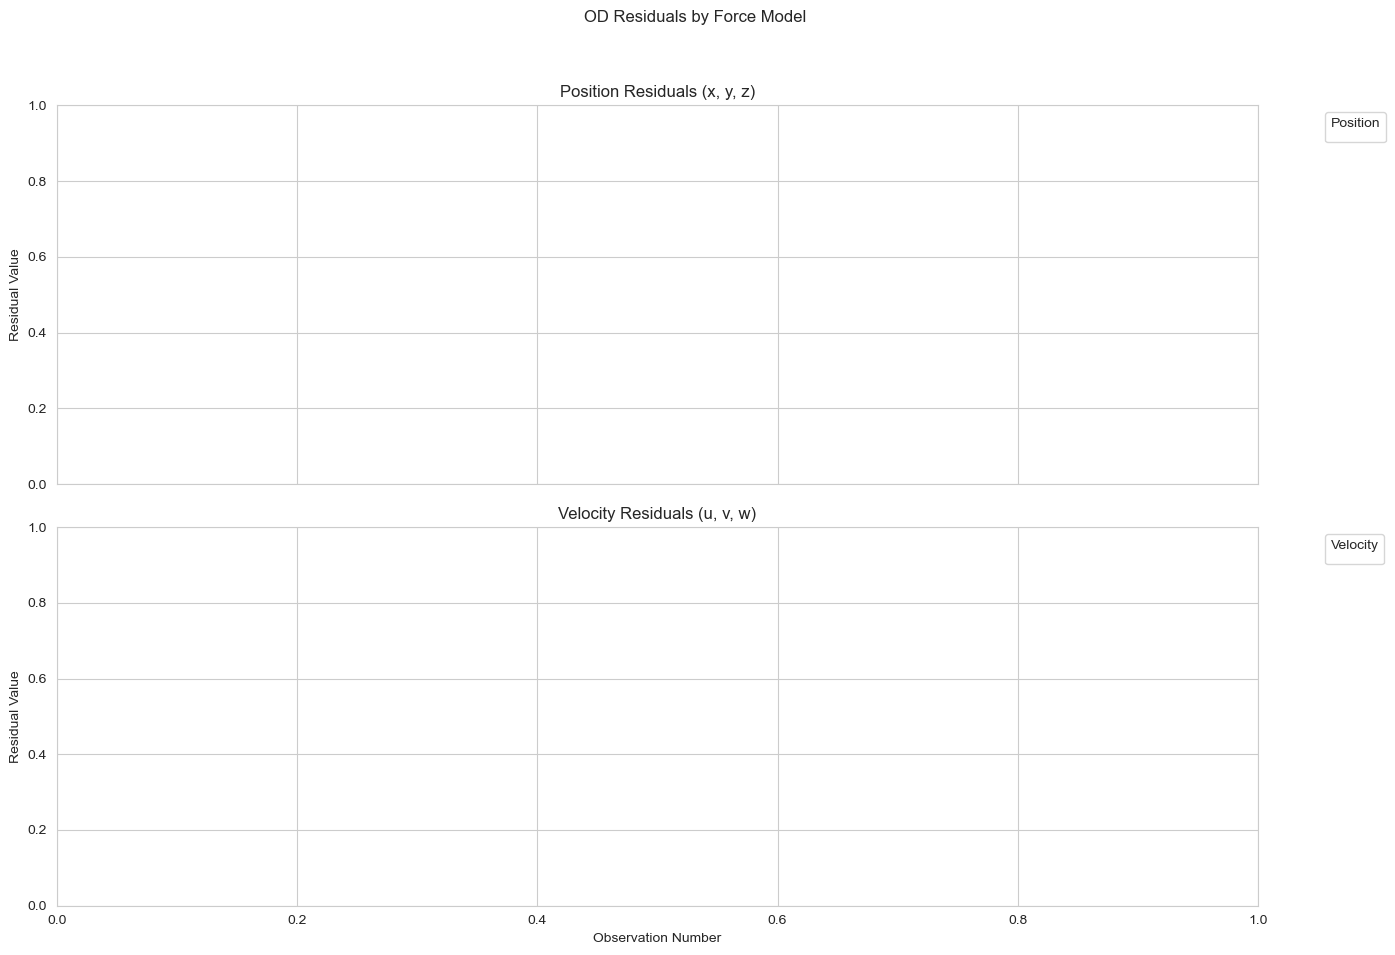

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Base folder path and satellites to test
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]

# Prepare the plot
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.suptitle('OD Residuals by Force Model')

# Define colors and labels for the plot
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
position_labels = ['x', 'y', 'z']
velocity_labels = ['u', 'v', 'w']

# Function to extract force model number from directory name
def extract_fm_number(dir_name):
    match = re.search(r'fm(\d+)', dir_name)
    if match:
        return int(match.group(1))
    else:
        return None

# Loop through each satellite and its subdirectories to find and plot OD residuals
for sat_name in sat_names_to_test:
    sat_folder_path = os.path.join(base_folder_path, sat_name)
    
    # Walk through the satellite's directory to find all RMSs.npy and corresponding ODresiduals.npy files
    for root, dirs, files in os.walk(sat_folder_path):
        if 'RMSs.npy' in files:
            fmodel_number = extract_fm_number(root)
            if fmodel_number is not None:
                color = colors[(fmodel_number - 1) % len(colors)]
                label = f'FM {fmodel_number}'
                
                # Load RMS and OD residuals
                RMSs_path = os.path.join(root, 'RMSs.npy')
                residuals_path = os.path.join(root, 'ODresiduals.npy')
                
                RMSs = np.load(RMSs_path)
                od_residuals = np.load(residuals_path)
                min_RMS_index = np.argmin(RMSs)
                selected_residuals = od_residuals[min_RMS_index]

                # Plot position residuals
                for i, label in enumerate(position_labels):
                    axs[0].plot(selected_residuals[:, i], label=f'{label} {fmodel_number}', color=color)
                
                # Plot velocity residuals
                for i, label in enumerate(velocity_labels, start=3):
                    axs[1].plot(selected_residuals[:, i], label=f'{label} {fmodel_number}', color=color)

# Configure subplots and legends
axs[0].set_title('Position Residuals (x, y, z)')
axs[1].set_title('Velocity Residuals (u, v, w)')
axs[1].set_xlabel('Observation Number')
axs[0].set_ylabel('Residual Value')
axs[1].set_ylabel('Residual Value')
axs[0].legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].legend(title='Velocity', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Satellite GRACE-FO-A, Arc 1, RMS went from 0.2556967052876375 to 0.23866721498610716 - % change of 6.66
Satellite GRACE-FO-A, Arc 1, RMS went from 0.23866721498610716 to 0.0060870129932131135 - % change of 97.45
Satellite GRACE-FO-A, Arc 2, RMS went from 0.003192476953797661 to 0.0026337339325630854 - % change of 17.50
Satellite GRACE-FO-A, Arc 2, RMS went from 0.0026337339325630854 to 0.0027935817420111377 - % change of -6.07
Satellite GRACE-FO-A, Arc 3, RMS went from 0.004716208317955943 to 0.005880181402824361 - % change of -24.68
Satellite GRACE-FO-A, Arc 3, RMS went from 0.005880181402824361 to 0.0058260998327051795 - % change of 0.92
Satellite GRACE-FO-B, Arc 1, RMS went from 0.005252553686360306 to 0.006408897291838407 - % change of -22.01
Satellite GRACE-FO-B, Arc 1, RMS went from 0.006408897291838407 to 0.006327353445392799 - % change of 1.27
Satellite GRACE-FO-B, Arc 2, RMS went from 0.003218289304165267 to 0.0025791334266822095 - % change of 19.86
Satellite GRACE-FO-B, Arc 2

/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_21661/2437018837.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(x='Improvement', y='Force_Model_Transition', hue='Satellite', data=df_improvements, orient='h', palette=palette, ci=None)


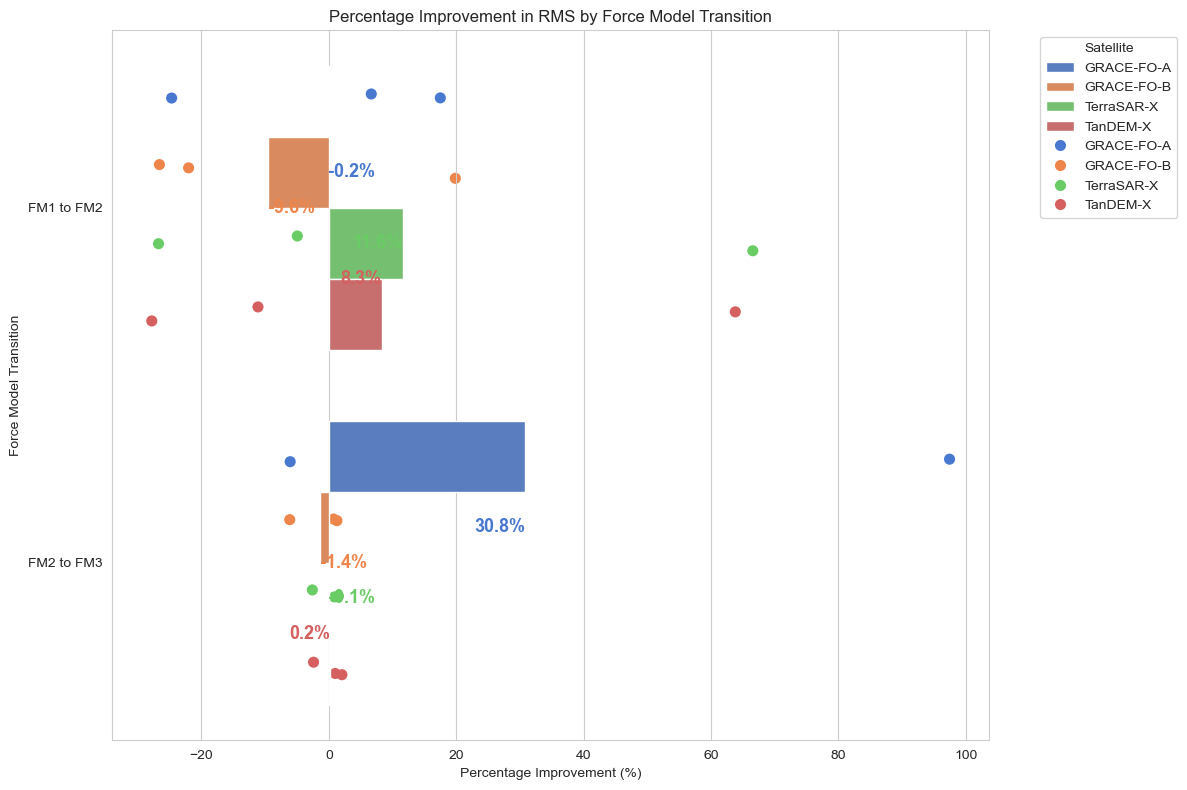

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from matplotlib import patheffects

# Base folder path and satellites
base_folder_path = "output/OD_BLS/Tapley/saved_runs"
sat_names_to_test = ["GRACE-FO-A", "GRACE-FO-B", "TerraSAR-X", "TanDEM-X"]

# Function to parse details from the folder name
def parse_folder_details(folder_name):
    fm_match = re.search(r'fm(\d+)', folder_name)
    arc_match = re.search(r'arc(\d+)', folder_name)
    fm = int(fm_match.group(1)) if fm_match else None
    arc = int(arc_match.group(1)) if arc_match else None
    return fm, arc

# Initialize list for data
improvements_data = []

# Process directories
for sat_name in sat_names_to_test:
    rms_values = {}  # (force_model, arc) : RMS

    for root, dirs, files in os.walk(os.path.join(base_folder_path, sat_name)):
        for file in files:
            if file == 'RMSs.npy':
                fm, arc = parse_folder_details(root)
                if fm and arc:
                    rms_path = os.path.join(root, file)
                    rms = np.min(np.load(rms_path))
                    rms_values[(fm, arc)] = rms

    sorted_keys = sorted(rms_values.keys(), key=lambda x: (x[1], x[0]))  # Sort by arc, then by FM for correct sequential processing
    for i in range(1, len(sorted_keys)):
        prev_key, curr_key = sorted_keys[i-1], sorted_keys[i]
        # Ensure the comparison is for the same arc and consecutive force models
        if prev_key[1] == curr_key[1] and curr_key[0] == prev_key[0] + 1:
            prev_rms, curr_rms = rms_values[prev_key], rms_values[curr_key]
            improvement = (prev_rms - curr_rms) / prev_rms * 100
            print(f"Satellite {sat_name}, Arc {curr_key[1]}, RMS went from {prev_rms} to {curr_rms} - % change of {improvement:.2f}")
            improvements_data.append({
                'Satellite': sat_name,
                'Force_Model_Transition': f'FM{prev_key[0]} to FM{curr_key[0]}',
                'Improvement': improvement
            })

# Create DataFrame
df_improvements = pd.DataFrame(improvements_data)

# Assuming df_improvements and the plot setup is as before

plt.figure(figsize=(12, 8))

# Define your color palette to match the number of satellites
palette = sns.color_palette("muted", n_colors=len(pd.unique(df_improvements['Satellite'])))

# Create the barplot
barplot = sns.barplot(x='Improvement', y='Force_Model_Transition', hue='Satellite', data=df_improvements, orient='h', palette=palette, ci=None)

#add stripplot
sns.stripplot(x='Improvement', y='Force_Model_Transition', hue='Satellite', data=df_improvements, orient='h', palette=palette, dodge=True, size=8, alpha=1, zorder=0)
# Customizing the legend properly
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Satellite', bbox_to_anchor=(1.05, 1), loc='upper left')

# Find unique force model transitions and satellites
force_model_transitions = df_improvements['Force_Model_Transition'].unique()
satellites = df_improvements['Satellite'].unique()

# Iterate through each force model transition
for i, transition in enumerate(force_model_transitions):
    # Filter the DataFrame for this transition
    transition_data = df_improvements[df_improvements['Force_Model_Transition'] == transition]
    # Calculate the base y-position for this transition's bars
    base_y_pos = i
    
    # Iterate through each satellite to place annotations
    for j, satellite in enumerate(satellites):
        satellite_data = transition_data[transition_data['Satellite'] == satellite]
        if not satellite_data.empty:
            # Calculate the average improvement for this satellite and transition
            avg_improvement = satellite_data['Improvement'].mean()
            # Adjust y-position for the specific satellite's bar within the group
            adjusted_y_pos = base_y_pos - 0.1 + (0.4 * j / len(satellites))
            # Annotate
            plt.text(avg_improvement, adjusted_y_pos, f'{avg_improvement:.1f}%', color=palette[j], ha='left' if avg_improvement < 0 else 'right', va='center', fontsize=13, fontweight='bold')

plt.title('Percentage Improvement in RMS by Force Model Transition')
plt.xlabel('Percentage Improvement (%)')
plt.ylabel('Force Model Transition')

plt.tight_layout()
plt.show()